In [1]:
import os, glob, shutil
import mne, math
import numpy as np
import scipy.io as io
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import h5py

from mne.baseline import rescale
from mne.time_frequency import tfr_array_multitaper

In [2]:
# variables
subj = 'sub-002'
bids_dir = '/Users/knapen/projects/prf-seeg/data/bids'
derivatives_dir = '/Users/knapen/projects/prf-seeg/data/derivatives'
analysis_stage = 'preprocessing'

run = 4
target_el = 'L'

durations_one_pRF_expt = np.array([2, 6, 6, 2, 6, 6, 2, 6, 6, 2, 6, 6, 2])
expts_in_run = 6

bar_blank_bools = np.array([0,1,1]*4+[0], dtype=bool)

In [3]:
edf_file = f'{subj}_run-{str(run).zfill(2)}_task-pRF_acq-2kHz.edf'
raw_data = mne.io.read_raw_edf(os.path.join(bids_dir, subj, 'func', edf_file))
# /Users/knapen/projects/prf-seeg/data/bids/{subj}/func/{subj}_run-03_task-pRF_acq-2kHz.edf

evt_tsv_file = f'{subj}_run-{str(run).zfill(2)}_task-pRF_events.tsv'
fix_tsv_file = f'{subj}_run-{str(run).zfill(2)}_task-pRF_fix_responses.tsv'
exp_yml_file = f'{subj}_run-{str(run).zfill(2)}_task-pRF_expsettings.yml'
seq_timing_h5_file = f'{subj}_run-{str(run).zfill(2)}_task-pRF_seq_timing.h5'
aperture_h5_file = f'{subj}_run-{str(run).zfill(2)}_task-pRF_apertures.h5'

Extracting EDF parameters from /Users/knapen/projects/prf-seeg/data/bids/sub-002/func/sub-002_run-04_task-pRF_acq-2kHz.edf...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
A3, A4, A5, A6, A7, A8, A9, A10, A13, A14, A15, A16, E, C7, A11, A12, C8, C9, C10, C11, C12, DC09, DC10, DC11, DC12, DC13, DC14, DC15, DC16, F11, F12, H1, H2, H3, H4, H5, H6, H7, H8, H9, H10, H11, H12, H13, H14, H15, H16, J1, J2, J3, J4, J5, J6, J7, J8, J9, J10, J11, J12, J13, J14, J15, J16, L1, L2, L3, L4, L5, L6, L7, L8, L9, L10, L11, L12, L13, L14, L15, L16, X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, Y1, Y2, Y3, Y4, Y5, Y6, Y7, Y8, Y9, Y10, Y11, Y12, Y13, Y14, Y15, Y16, Z1, Z2, Z3, Z4, Z5, Z6, Z7, Z8, Z9, Z10, Z11, Z12, Z13, Z14, Z15, Z16, A'1, A'2, A'3, A'4, A'5, A'6, A'7, A'8, A'9, A'10, A'11, A'12, A'13, A'14, A'15, A'16, H'1, H'2, H'3, H'4, H'5, H'6, H'7, H'8, H'9, H'10, H'11, H'12, H'13, H'14

In [4]:
fn = os.path.join(bids_dir, subj, 'func', seq_timing_h5_file)
f = h5py.File(os.path.join(bids_dir, subj, 'func', seq_timing_h5_file), 'r')
ks = list(f.keys())
f.close()

print(ks)

st = {}
for k in ks:
    print(k)
    st.update({k: pd.read_hdf(fn, key=f'{k}/bg_imgs', mode='r')})

print(st)
    

['trial_003', 'trial_004', 'trial_006', 'trial_007', 'trial_009', 'trial_010', 'trial_012', 'trial_013', 'trial_016', 'trial_017', 'trial_019', 'trial_020', 'trial_022', 'trial_023', 'trial_025', 'trial_026', 'trial_029', 'trial_030', 'trial_032', 'trial_033', 'trial_035', 'trial_036', 'trial_038', 'trial_039', 'trial_042', 'trial_043', 'trial_045', 'trial_046', 'trial_048', 'trial_049', 'trial_051', 'trial_052', 'trial_055', 'trial_056', 'trial_058', 'trial_059', 'trial_061', 'trial_062', 'trial_064', 'trial_065', 'trial_068', 'trial_069', 'trial_071', 'trial_072', 'trial_074', 'trial_075', 'trial_077', 'trial_078']
trial_003
trial_004
trial_006
trial_007
trial_009
trial_010
trial_012
trial_013
trial_016
trial_017
trial_019
trial_020
trial_022
trial_023
trial_025
trial_026
trial_029
trial_030
trial_032
trial_033
trial_035
trial_036
trial_038
trial_039
trial_042
trial_043
trial_045
trial_046
trial_048
trial_049
trial_051
trial_052
trial_055
trial_056
trial_058
trial_059
trial_061
trial

## Trigger Events
get the trigger events from the 'DC' channels

In [5]:
print(raw_data.ch_names)

['A1-Ref', 'A2-Ref', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A13', 'A14', 'A15', 'A16', 'C1-Ref', 'C2-Ref', 'C3-Ref', 'C4-Ref', 'C5-Ref', 'E', 'C6-Ref', 'C7', 'A11', 'A12', 'C8', 'C9', 'C10', 'C11', 'C12', 'F1-Ref', 'F2-Ref', 'F3-Ref', 'F4-Ref', 'F5-Ref', 'F6-Ref', 'F7-Ref', 'F8-Ref', 'DC09', 'DC10', 'DC11', 'DC12', 'DC13', 'DC14', 'DC15', 'DC16', 'F9-Ref', 'F10-Ref', 'F11', 'F12', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 'J8', 'J9', 'J10', 'J11', 'J12', 'J13', 'J14', 'J15', 'J16', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'Z10', 'Z11', 'Z12', 'Z13', 'Z14', '

In [6]:
blank_channel = 0
bar_channel = 1

# dc_channels = [f'POL DC{str(i).zfill(2)}' for i in [blank_channel, bar_channel]]
dc_channels_indx = [True if 'DC' in ch else False for ch in raw_data.ch_names]
dc_channels = np.array(raw_data.ch_names)[np.array(dc_channels_indx)]
dc_channels

array(['DC09', 'DC10', 'DC11', 'DC12', 'DC13', 'DC14', 'DC15', 'DC16'],
      dtype='<U7')

In [7]:
raw_data.load_data()
raw_data.notch_filter([50,100,150], picks=np.arange(len(dc_channels_indx))[~np.array(dc_channels_indx)])
raw_data.resample(500, stim_picks=np.arange(len(dc_channels_indx))[np.array(dc_channels_indx)])

dc_data = raw_data.get_data(picks=dc_channels)

Reading 0 ... 942027  =      0.000 ...   471.013 secs...
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13201 samples (6.600 sec)



[5 6 7 3 4 2 0 1]


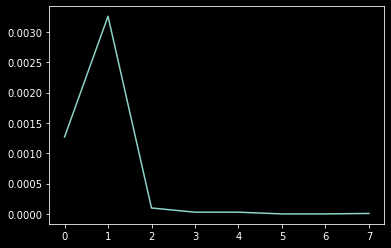

In [8]:
# plt.plot(dc_data.T)
plt.plot(dc_data.var(1))
print(np.argsort(dc_data.var(1)))

In [9]:
def timings_from_channel(channel_data, ll=4, doublure_rej_interval=10):
    baseline = np.median(channel_data)
    spread = np.std(channel_data)
    overs = channel_data > baseline+ll*spread
    onsets = np.r_[np.diff(overs)>0, False]
    onset_indx = np.arange(channel_data.shape[0])[onsets]
    singular_onset_idxs = np.ones_like(onset_indx, dtype=bool)
    for i in range(1, onset_indx.shape[0]):
        delay = onset_indx[i] - onset_indx[i-1]
        if delay < doublure_rej_interval:
            # print(f'throwing out {onset_indx[i]} for delay {delay} < {doublure_rej_interval}')
            singular_onset_idxs[i] = False
    return onsets, onset_indx[singular_onset_idxs]


blank_onsets, blank_onset_indx = timings_from_channel(dc_data[blank_channel])
bar_onsets, bar_onset_indx = timings_from_channel(dc_data[bar_channel])

(50000.0, 100000.0)

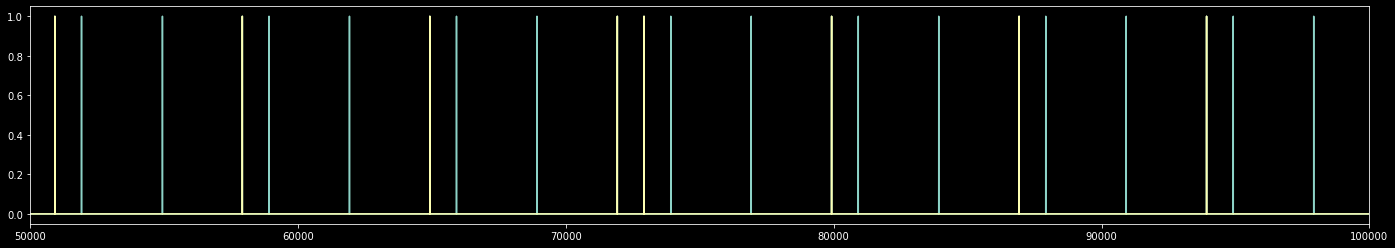

In [10]:
plt.figure(figsize=(24,4))
plt.plot(bar_onsets)
plt.plot(blank_onsets)
plt.xlim([50000,1e5])

In [47]:
data_onset_idx = blank_onset_indx[0]
print(data_onset_idx)
print(raw_data.ch_names)
print(len(blank_onset_indx), len(bar_onset_indx))
print(blank_onset_indx, bar_onset_indx)
bar_onset_indx = np.setdiff1d(bar_onset_indx, blank_onset_indx)
bar_onset_indx.dtype

43410
['A1-Ref', 'A2-Ref', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A13', 'A14', 'A15', 'A16', 'C1-Ref', 'C2-Ref', 'C3-Ref', 'C4-Ref', 'C5-Ref', 'E', 'C6-Ref', 'C7', 'A11', 'A12', 'C8', 'C9', 'C10', 'C11', 'C12', 'F1-Ref', 'F2-Ref', 'F3-Ref', 'F4-Ref', 'F5-Ref', 'F6-Ref', 'F7-Ref', 'F8-Ref', 'DC09', 'DC10', 'DC11', 'DC12', 'DC13', 'DC14', 'DC15', 'DC16', 'F9-Ref', 'F10-Ref', 'F11', 'F12', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 'J8', 'J9', 'J10', 'J11', 'J12', 'J13', 'J14', 'J15', 'J16', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'Z10', 'Z11', 'Z12', 'Z13', 'Z

dtype('int64')

In [137]:
# non_data_channels = ['ECG', 'DELT', 'EEG']
# ndcbools = np.zeros((len(raw_data.ch_names),len(non_data_channels)), dtype=bool)
# for i,rcn in enumerate(raw_data.ch_names):
#     for j,ndc in enumerate(non_data_channels):
#         ndcbools[i,j] = ndc in rcn
# plt.plot(ndcbools)
# print(non_data_channels[1] in 'L-DELT1', 'L-DELT1', non_data_channels[1])

# for rcn in raw_data.ch_names:
#     print(rcn, np.array([False if ndc in rcn else True for ndc in non_data_channels]).prod(dtype=bool))

# np.array([np.array([False if ndc in rcn else True for ndc in non_data_channels]).prod(dtype=bool) for rcn in raw_data.ch_names])
raw_data.info.keys()


dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

In [98]:
evt_data = pd.read_csv(os.path.join(bids_dir, subj, 'func', evt_tsv_file), sep='\t')
start_time = evt_data[evt_data.event_type == 'pulse'].onset_abs.values[0]
trial_data = evt_data[evt_data.event_type == 'stim'][['bar_direction', 'bar_width', 'bar_refresh_time', 'onset_abs']]
trial_data = trial_data[~np.isnan(trial_data['bar_width'].values)]
trial_data['onset_time'] = trial_data.onset_abs - start_time
trial_data.reindex(index=np.arange(trial_data.shape[0]))

# trial_data[trial_data.bar_width == -1.0]['eeg_trigger_time'] = blank_onset_indx
# trial_data[trial_data.bar_width != -1.0].shape#['eeg_trigger_time'] = bar_onset_indx
# blank_onset_indx, blank_onset_indx.shape, bar_onset_indx, bar_onset_indx.shape
# np.diff(bar_onset_indx), np.diff(blank_onset_indx), trial_data[trial_data.bar_width == -1.0], trial_data[trial_data.bar_width != -1.0]

tdf = pd.DataFrame(np.r_[bar_onset_indx.astype(int), blank_onset_indx.astype(int)], columns=['eeg_tt'])
tdf['category'] = ['bar' for bi in bar_onset_indx]+['blank' for bi in blank_onset_indx]
tdf = tdf.sort_values(by='eeg_tt')
# tdf = tdf.loc[1:]
tdf.reset_index(inplace=True)
tdf.drop(0, inplace=True)
tdf.reset_index(inplace=True)
tdf.reindex(index=np.arange(trial_data.shape[0]))
# np.array([np.r_[bar_onset_indx.astype(int), blank_onset_indx.astype(int)], ['bar' for bi in bar_onset_indx]+['blank' for bi in blank_onset_indx]], dtype=(int, str)).T


level_0  index  eeg_tt category
0         1     49   43914    blank
1         2      0   44914      bar
2         3      1   47923      bar
3         4     50   50919    blank
4         5      2   51915      bar
..      ...    ...     ...      ...
73       74     45  206918      bar
74       75     77  209918    blank
75       76     46  210910      bar
76       77     47  213919      bar
77       78     78  216919    blank

[78 rows x 4 columns]

In [99]:
trial_data.reset_index(inplace=True)
trial_data = pd.concat((trial_data, tdf[['eeg_tt', 'category']]), axis=1)

In [108]:
.eeg_tt.iloc[-1]

index  bar_direction  bar_width  bar_refresh_time   onset_abs  onset_time  \
0       5           -1.0       -1.0          1.000000   40.691768    1.030283   
1       7            0.0        0.2          0.500000   42.750339    3.088853   
2       9          225.0        0.2          0.500000   48.734028    9.072542   
3      11           -1.0       -1.0          1.000000   54.709147   15.047661   
4      13           90.0        0.2          0.500000   56.709354   17.047868   
..    ...            ...        ...               ...         ...         ...   
73    179           45.0        0.3          0.066667  366.730720  327.069234   
74    181           -1.0       -1.0          1.000000  372.714154  333.052668   
75    183          270.0        0.3          0.066667  374.706042  335.044556   
76    186          135.0        0.3          0.066667  380.730720  341.069234   
77    189           -1.0       -1.0          1.000000  386.714673  347.053188   

    eeg_tt category  
0    43914    blank  
1    44914      bar  
2    47923      bar  
3    50919    blank  
4    51915      bar  
..     ...      ...  
73  206918      bar  
74  209918    blank  
75  210910      bar  
76  213919      bar  
77  216919    blank  

[78 rows x 8 columns]

[1, 14, 27, 40, 53, 66]


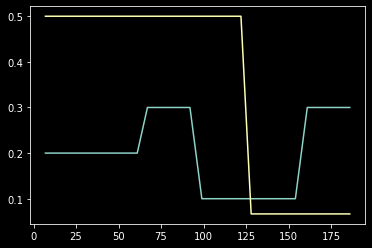

In [13]:
bar_widths = [trial_data.iloc[durations_one_pRF_expt.shape[0]*i+1].bar_width for i in range(expts_in_run)]
bar_refresh_times = [trial_data.iloc[durations_one_pRF_expt.shape[0]*i+1].bar_refresh_time for i in range(expts_in_run)]

print([durations_one_pRF_expt.shape[0]*i+1 for i in range(expts_in_run)])

plt.plot(trial_data.bar_width[trial_data.bar_width>0])
plt.plot(trial_data.bar_refresh_time[trial_data.bar_width>0])

## Now, get data from all other channels
the non-DC channels should contain signals

In [14]:
# raw_data.chnames
data_channels = [ch for ch in raw_data.ch_names if f'{target_el}' in ch]

# data_channels = [ch for ch in raw_data.ch_names if ch not in dc_channels]
raw_data_np = raw_data.get_data(picks=data_channels, start=data_onset_idx)

In [109]:
freqs = np.logspace(0.3, 2.3, 200)
print(np.log10(450), freqs)

raw_data.save?

2.6532125137753435 [  1.99526231   2.0419742    2.08977968   2.13870435   2.18877442
   2.2400167    2.29245863   2.3461283    2.40105446   2.45726651
   2.51479456   2.57366943   2.63392264   2.69558646   2.75869392
   2.82327881   2.88937573   2.95702006   3.02624805   3.09709676
   3.16960414   3.24380901   3.31975113   3.39747116   3.47701072
   3.55841242   3.64171984   3.72697761   3.81423138   3.90352789
   3.99491495   4.08844151   4.18415766   4.28211465   4.38236496
   4.48496227   4.58996153   4.69741896   4.80739213   4.91993992
   5.03512261   5.15300189   5.27364089   5.39710421   5.52345799
   5.65276989   5.78510916   5.92054667   6.05915497   6.20100828
   6.34618258   6.49475562   6.64680695   6.80241802   6.96167216
   7.12465467   7.29145283   7.46215596   7.63685549   7.81564499
   7.9986202    8.18587911   8.37752202   8.57365155   8.77437276
   8.97979313   9.19002267   9.40517399   9.6253623    9.85070553
  10.08132436  10.31734229  10.55888574  10.80608406  11.

Signature:
raw_data.save(
    fname,
    picks=None,
    tmin=0,
    tmax=None,
    buffer_size_sec=None,
    drop_small_buffer=False,
    proj=False,
    fmt='single',
    overwrite=False,
    split_size='2GB',
    split_naming='neuromag',
    verbose=None,
)
Docstring:
Save raw data to file.

Parameters
----------
fname : str
    File name of the new dataset. This has to be a new filename
    unless data have been preloaded. Filenames should end with
    ``raw.fif`` (common raw data), ``raw_sss.fif``
    (Maxwell-filtered continuous data),
    ``raw_tsss.fif`` (temporally signal-space-separated data),
    ``_meg.fif`` (common MEG data), ``_eeg.fif`` (common EEG data),
    or ``_ieeg.fif`` (common intracranial EEG data). You may also
    append an additional ``.gz`` suffix to enable gzip compression.
picks : str | list | slice | None
    Channels to include. Slices and lists of integers will be interpreted as channel indices. In lists, channel *type* strings
    (e.g., ``['meg', 'eeg'

In [ ]:

tfr_data = tfr_array_multitaper(
    raw_data_np[np.newaxis, ...], sfreq=500, freqs=freqs, n_jobs=4, decim=5, output='power')


In [16]:
dfs = [pd.DataFrame(tfr_data[0,el].T, columns=freqs, index=np.arange(0,tfr_data.shape[-1]*0.01, 0.01)) for el in np.arange(tfr_data.shape[1])]
for i, df in enumerate(dfs):
    df.to_hdf(os.path.join(derivatives_dir, analysis_stage,
            subj, edf_file.replace('.edf', '_tfr.h5')), key=f'{target_el}_{str(i).zfill(2)}', mode='a')


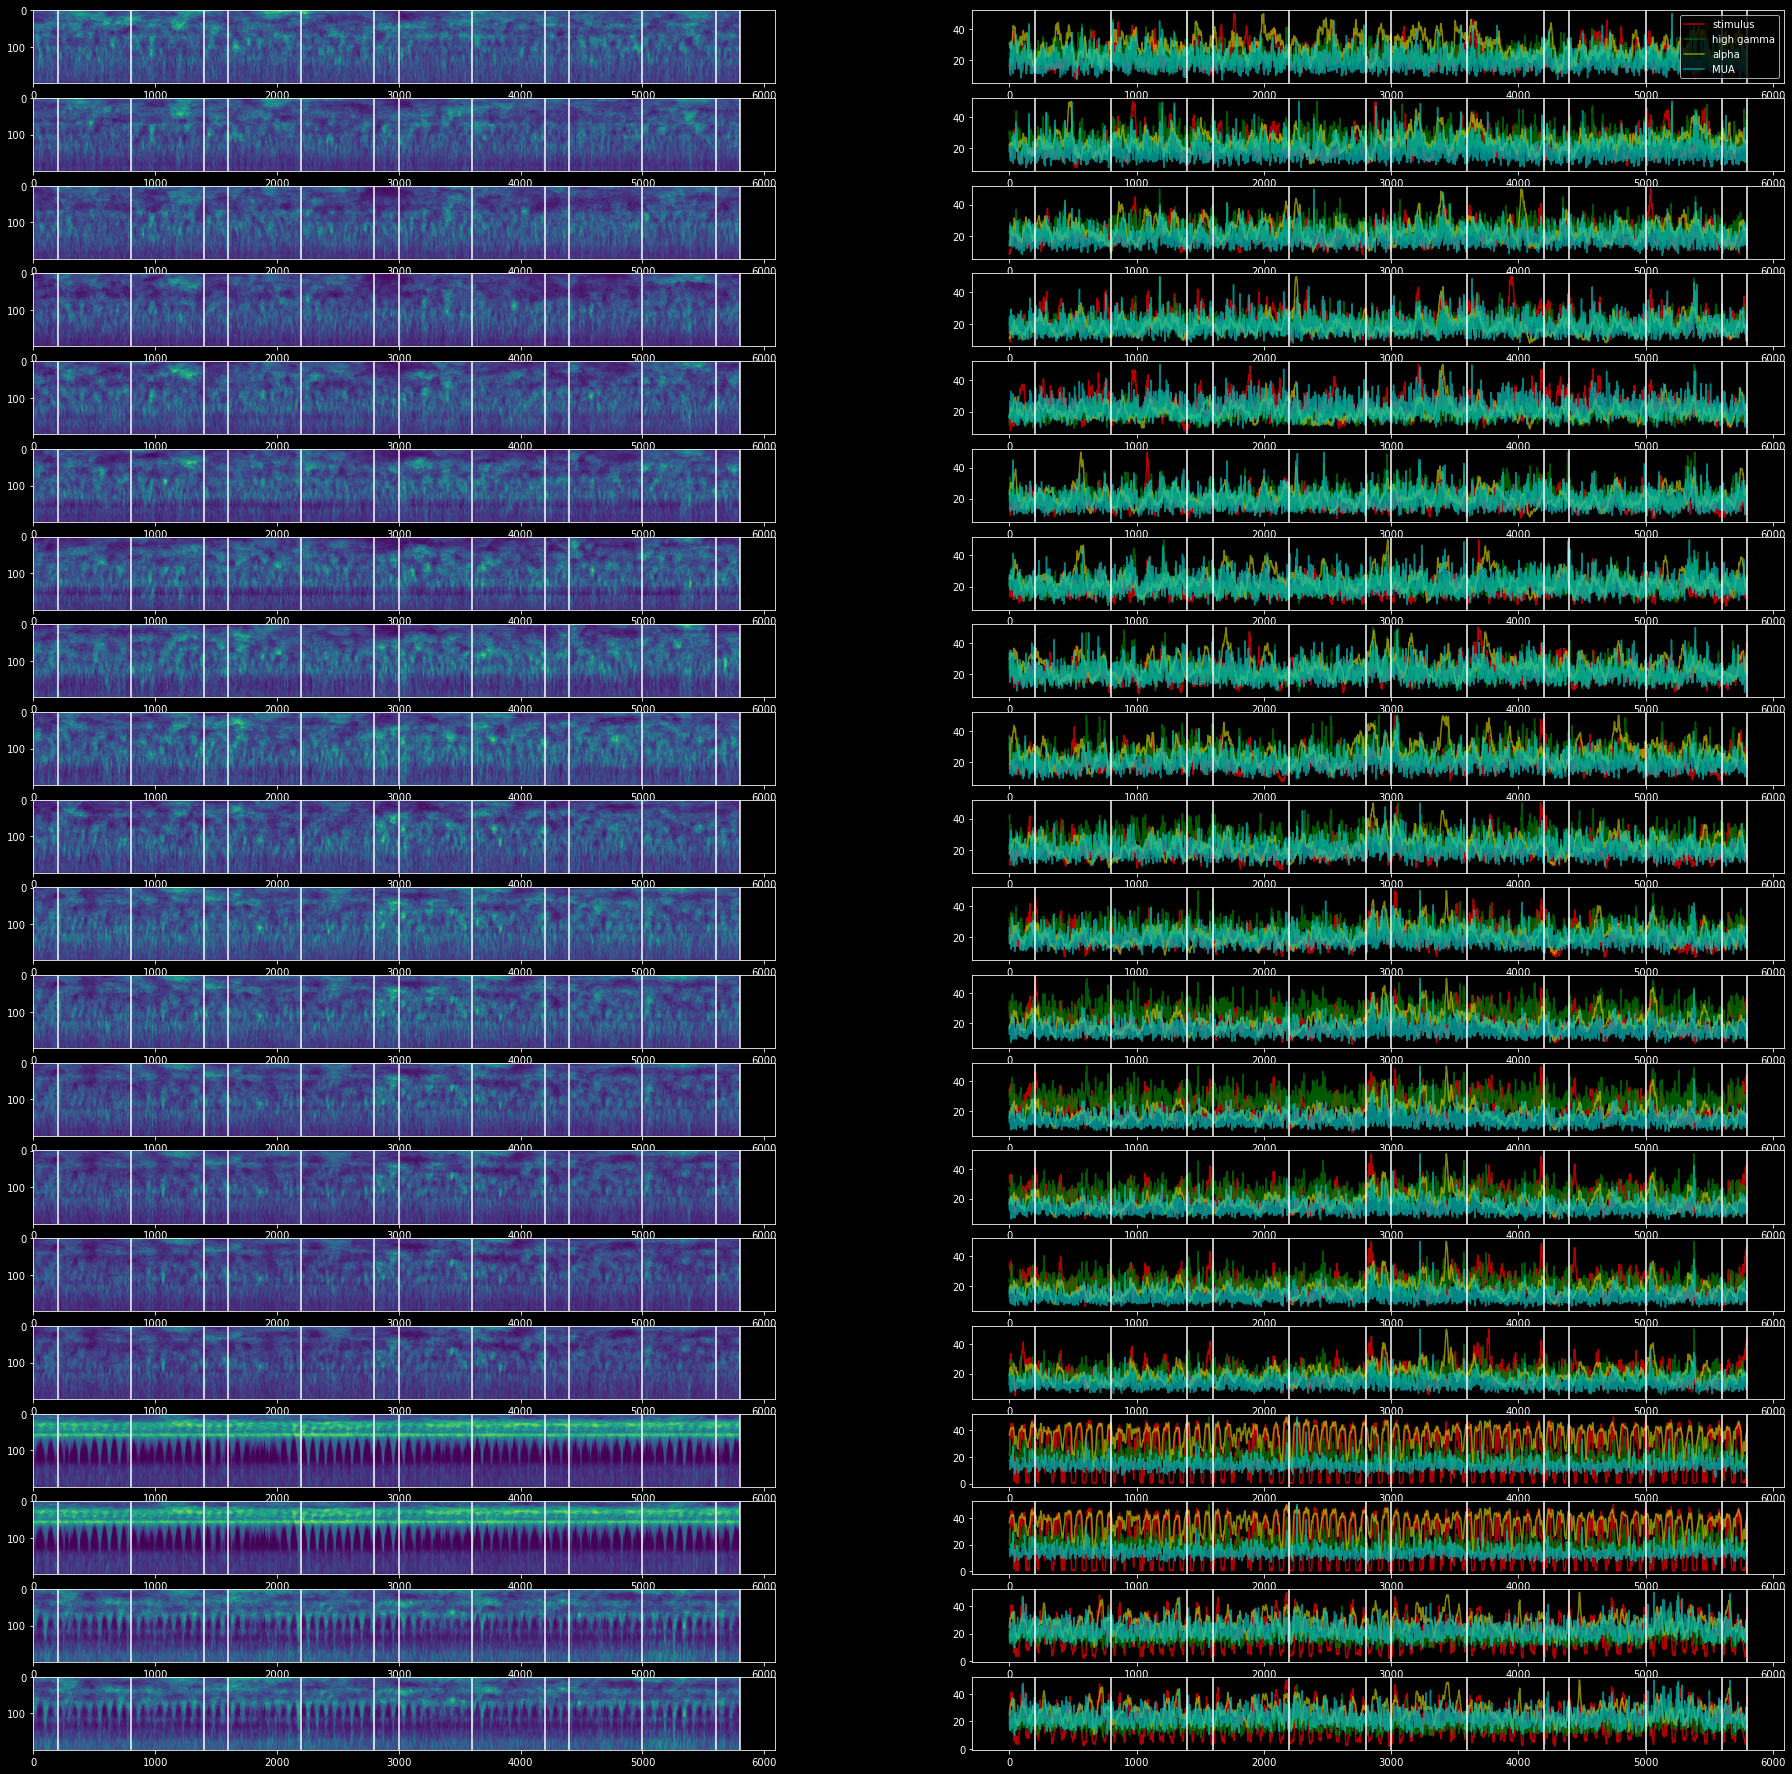

In [17]:
# plt.plot(tfr_data[0,0,:,::10].T)
present_sample_rate = 100
single_run_dur = int(58*present_sample_rate)
stim_frequencies = (freqs < 16) & (freqs > 14)
hg_frequencies = (freqs < 120) & (freqs > 50)
alpha_frequencies = (freqs < 12) & (freqs > 8)
mua_frequencies = (freqs > 120)

f, axs = plt.subplots(tfr_data.shape[1], 2, figsize=(32, 32))
for k in range(tfr_data.shape[1]):  # electrodes
    tfr_m = np.zeros((tfr_data.shape[2], single_run_dur))
    for i, ch in enumerate(tfr_data[0, k]):  # frequencies
        rd = []
        for j in range(6):  # stim repeats
            start_j = int(j*single_run_dur)
            rd.append(ch[start_j:start_j+single_run_dur])
        rd = np.array(rd)
        rd /= rd.std(1)[:, np.newaxis]
        tfr_m[i] = np.median(rd, 0)
    axs[k,0].imshow(tfr_m, aspect=3)

    stim_power = tfr_m[stim_frequencies].mean(0)
    stim_power /= stim_power.max()
    axs[k,1].plot(stim_power*50, 'r', alpha=0.7, label='stimulus')
    hg_power = tfr_m[hg_frequencies].mean(0)
    hg_power /= hg_power.max()
    axs[k,1].plot(hg_power*50, 'g', alpha=0.7, label='high gamma')
    alpha_power = tfr_m[alpha_frequencies].mean(0)
    alpha_power /= alpha_power.max()
    axs[k,1].plot(alpha_power*50, 'y', alpha=0.7, label='alpha')
    mua_power = tfr_m[mua_frequencies].mean(0)
    mua_power /= mua_power.max()
    axs[k,1].plot(mua_power*50, 'c', alpha=0.7, label='MUA')
    if k == 0:
        axs[k,1].legend()

    for x in np.cumsum(durations_one_pRF_expt*present_sample_rate):
        axs[k, 0].axvline(x, c='w')
        axs[k, 1].axvline(x, c='w')
plt.savefig(os.path.join(derivatives_dir, analysis_stage,
            subj, edf_file.replace('.edf', f'_{target_el}.pdf')))


In [18]:
indices_1r = np.r_[0,np.cumsum(durations_one_pRF_expt*present_sample_rate)]
ranges_1r = np.array([indices_1r[:-1], indices_1r[1:], bar_blank_bools]).T

all_ranges = np.zeros((ranges_1r.shape[0]*expts_in_run, 3), dtype=int)
for i in range(expts_in_run):
    all_ranges[i*ranges_1r.shape[0]:(i+1)*ranges_1r.shape[0]] = ranges_1r + np.array([ranges_1r[-1,1], ranges_1r[-1,1], 0])
    
# data per condition; bar or not?
blank_tfr, bar_tfr = [], [] 
for ar in all_ranges:
    if ar[-1] == 0: # blank
        blank_tfr.append(np.squeeze(tfr_data)[...,ar[0]:ar[1]])
    else:
        bar_tfr.append(np.squeeze(tfr_data)[...,ar[0]:ar[1]])
# reset to samples in last dimension        
blank_tfr = np.array(blank_tfr).transpose((1,2,3,0)).reshape((tfr_data.shape[1],tfr_data.shape[2],-1))
bar_tfr = np.array(bar_tfr).transpose((1,2,3,0)).reshape((tfr_data.shape[1],tfr_data.shape[2],-1))        

In [19]:
# per second psd
bar_tfr_ps = np.array([bar_tfr[...,x:x+present_sample_rate].mean(-1) for x in range(0,bar_tfr.shape[-1], present_sample_rate)])
blank_tfr_ps = np.array([blank_tfr[...,x:x+present_sample_rate].mean(-1) for x in range(0,blank_tfr.shape[-1], present_sample_rate)])
bar_tfr_ps.shape

(288, 20, 200)

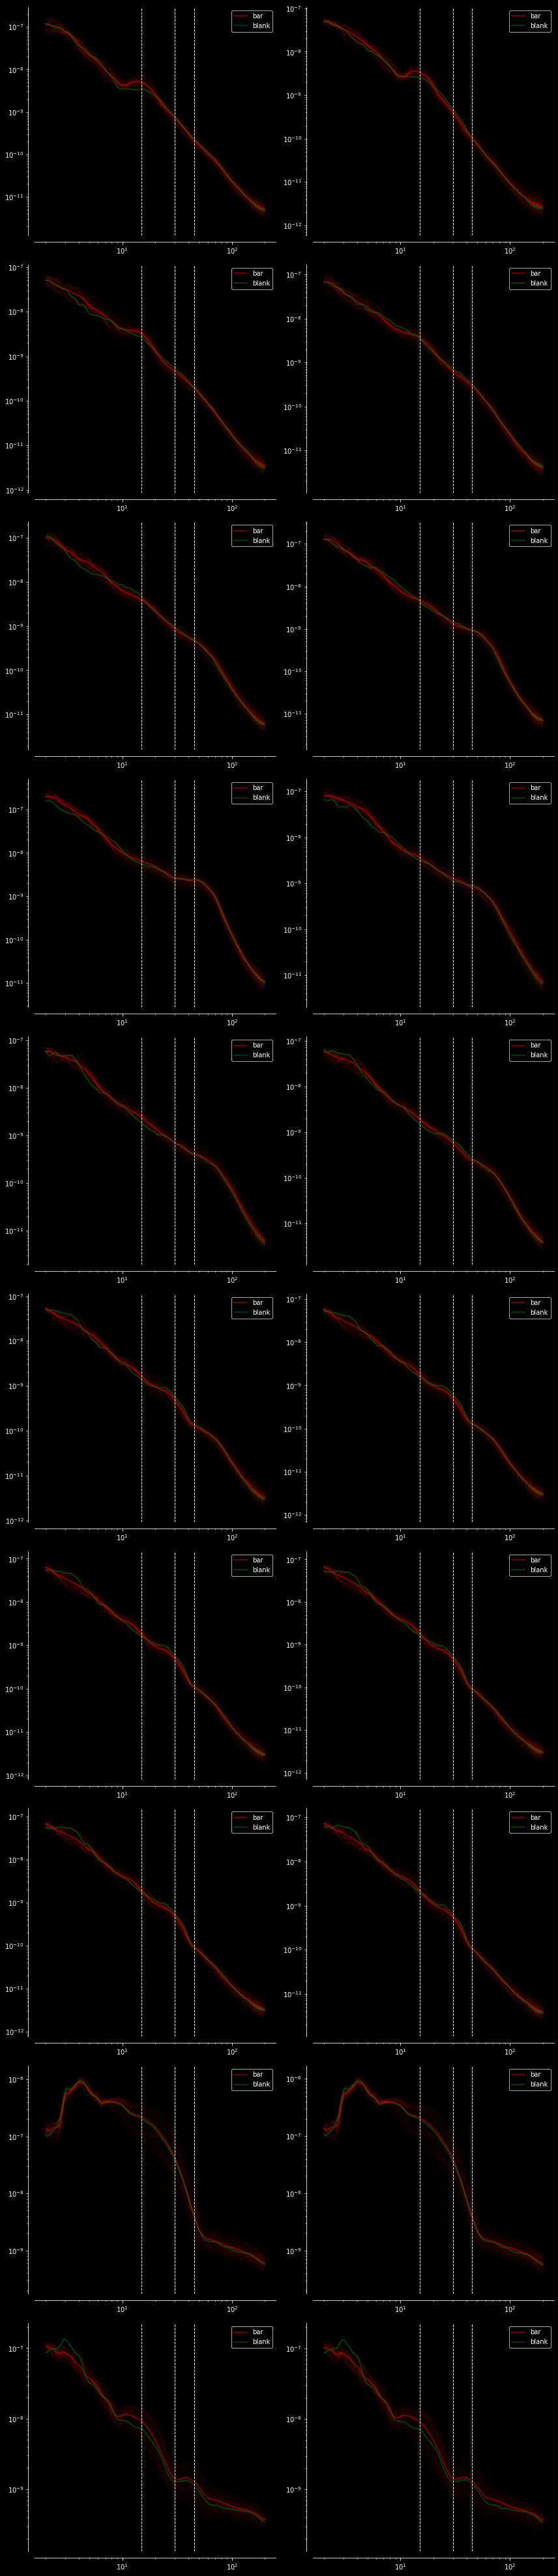

In [20]:
f, axs = plt.subplots(math.ceil(tfr_data.shape[1]/2), 2, figsize=(12,55))
for el in range(tfr_data.shape[1]):
    row=el//2
    col=el%2
    for x in range(bar_tfr_ps.shape[0]): # bar_tfr.shape[-1]
        axs[row,col].loglog(freqs, bar_tfr_ps[x,el,:], c='r', lw=0.25, alpha=0.05)
    for x in range(blank_tfr_ps.shape[0]): # bar_tfr.shape[-1]
        axs[row,col].loglog(freqs, blank_tfr_ps[x,el,:], c='g', lw=0.25, alpha=0.05)
    axs[row,col].loglog(freqs, bar_tfr_ps[:,el,:].mean(0), c='r', ls='-', lw=1.75, alpha=0.5, label='bar')
    axs[row,col].loglog(freqs, blank_tfr_ps[:,el,:].mean(0), c='g', ls='-', lw=1.75, alpha=0.5, label='blank')
    axs[row,col].axvline(x=15, c='w', ls='--', lw=1)
    axs[row,col].axvline(x=30, c='w', ls='--', lw=1)
    axs[row,col].axvline(x=45, c='w', ls='--', lw=1)
    axs[row,col].legend()
    # axs[el].set_aspect('equal')

sns.despine(fig=f, offset=10)
plt.tight_layout()
plt.savefig(os.path.join(derivatives_dir, analysis_stage,
            subj, edf_file.replace('.edf', f'_{target_el}_psd.bar-blank.pdf')))